2 objects detected !
3.490993022918701


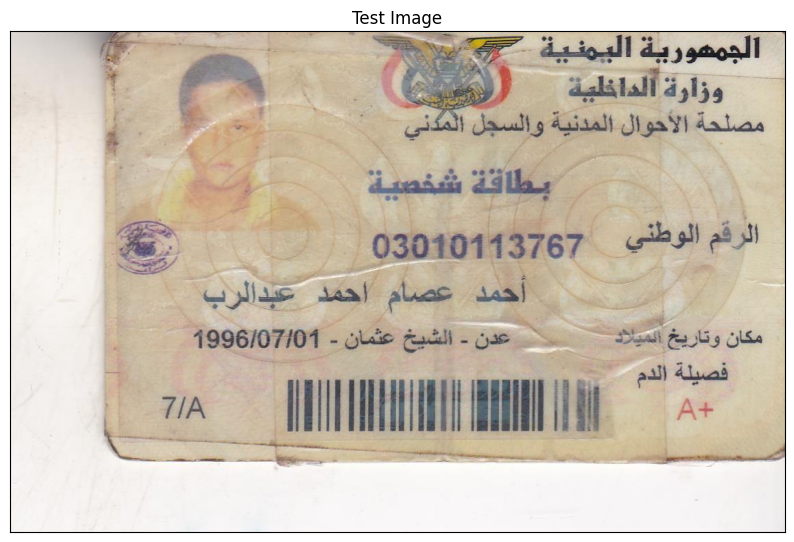

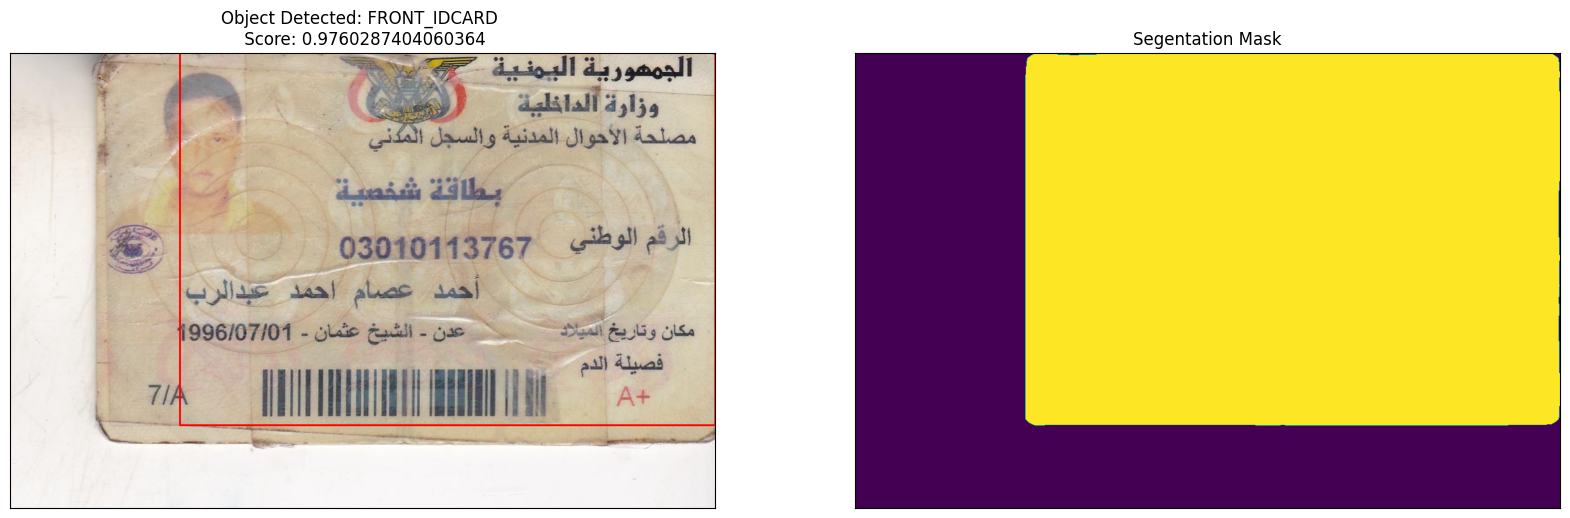

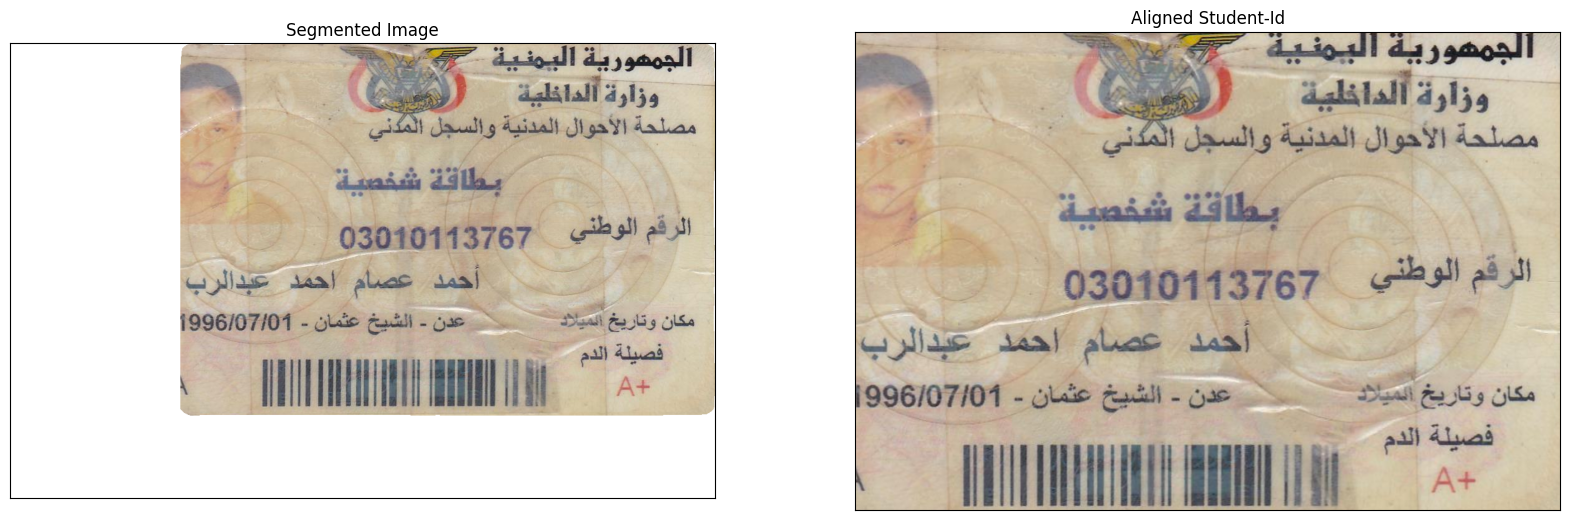

In [129]:
# import torch
# import torchvision
# import cv2
# import numpy as np
# from PIL import Image, ImageDraw, ImageFilter

import os
import cv2
import time
import torch
import torchvision

import numpy as np

import utils

from PIL import Image, ImageDraw, ImageFilter
#%matplotlib inline

from matplotlib import pyplot as plt
import modules.detection.scripts.transforms as detection_transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import modules.detection.scripts.utils as script_utils
from modules.detection.scripts.engine import train_one_epoch, evaluate

# define transforms to convert PIL image to torch.Tensor
imgToTensor = torchvision.transforms.ToTensor()
# define transforms to convert torch.Tensor to PIL image
tensorToPIL = torchvision.transforms.ToPILImage()
import time

start = time.time()

detection_classes = ['BACKGROUND', 'FRONT_IDCARD']



detection_model = torch.load("C:/Users/Amjad Adel/Desktop/pytorch-for-information-extraction/crop_front_idcard_model.pth", map_location=torch.device('cpu'))
image = Image.open('F:/New folder (2)/FrontIDCard/FirstSide_1_1040.jpeg')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
detection_model.to(device)
image_tensor = imgToTensor(image)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
ax.set_title('Test Image')
plt.imshow(image)

# put the model in evaluation mode
detection_model.eval()
with torch.no_grad():
    pass
    # forward pass the test image to get detection predictions
    detection_predictions = detection_model(image_tensor.unsqueeze(0).to(device))
print(detection_predictions[0]['labels'].size()[0], 'objects detected !')
detection_predictions[0]

idx = 0

image_array = np.array(image)
# Retrieve predicted bounding box for detected object
box_tensor = detection_predictions[0]['boxes'][idx]
box = [int(cord) for cord in box_tensor.cpu().numpy()]
# draw predicted bounding box on image
cv2.rectangle(image_array, (box[0],box[1]), (box[2],box[3]), (255,0,0), 2)

# Retrieve predicted mask for detected object
mask_tensor = detection_predictions[0]['masks'][idx]
# Threshold mask tensor
mask_tensor = mask_tensor > 0.5
mask_tensor = mask_tensor.float()

mask = tensorToPIL(mask_tensor)

# Retrieve predictied label for detected object
label_idx = detection_predictions[0]['labels'][idx].item()
label = detection_classes[label_idx]

# Retrieve predictied score for detected object
score = detection_predictions[0]['scores'][idx].item()

fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plt.imshow(image_array)
ax.set_title('Object Detected: {} \n Score: {}'.format(label, score))
ax1 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plt.imshow(mask)
ax1.set_title('Segentation Mask')
# from torch._dynamo.utils import is_guard_failure_reporting_enabled
def align_student_id(image, mask) :
    # Extract quadreploid of segmented image
    X = np.nonzero(mask)[1]
    Y = np.nonzero(mask)[0]
    points = np.vstack((X, Y)).T
    rect = utils.order_points(points)

    # align detected student id
    image_array = np.array(segmented_image)
    aligned_image_array = utils.warp_perspective_image(image_array, rect)
    aligned_image_array = cv2.cvtColor(aligned_image_array, cv2.COLOR_BGR2RGB)

    return Image.fromarray(aligned_image_array)

segmented_image = utils.segment_image(image, mask)
aligned_student_id = align_student_id(image, mask)

fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Segmented Image')
plt.imshow(segmented_image)

ax1 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax1.set_title('Aligned Student-Id',)
plt.imshow(aligned_student_id)
end = time.time()
print(end - start)
aligned_student_id.save('F:/New folder (2)/codealigned_image1.jpg')


In [130]:

import yaml

field_coordinates_file = './field_coordinates.yaml'
with open(field_coordinates_file) as f:
    field_coordinates = yaml.load(f, Loader=yaml.FullLoader)

# print field coordinates
field_coordinates


{'image_width': 324,
 'image_height': 204,
 'firstname': {'width': 240, 'height': 28, 'left': 0, 'top': 117},
 'birth_date': {'width': 90, 'height': 20, 'left': 35, 'top': 140},
 'photo': {'width': 110, 'height': 110, 'left': 0, 'top': 6},
 'signature': {'width': 190, 'height': 140, 'left': 65, 'top': 165},
 'id': {'width': 125, 'height': 35, 'left': 110, 'top': 90}}

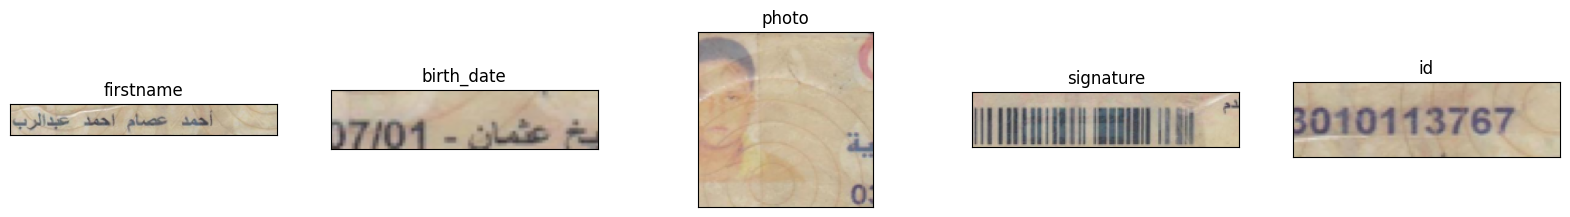

In [131]:
import math

aligned_image = Image.open('F:/New folder (2)/codealigned_image1.jpg')
# get size of aligned image
image_width = aligned_image.width
image_height = aligned_image.height

im_width = field_coordinates['image_width']
im_height = field_coordinates['image_height']

image_array = np.array(aligned_image.resize((im_width, im_height)))

num_col = 5
fig = plt.figure(figsize=(20, 5))
for counter, field_id in enumerate(field_coordinates):
    if field_id in ['image_width', 'image_height'] : continue
    cords = field_coordinates[field_id]
    x1, y1, x2, y2 = cords['left'], cords['top'], cords['width']+cords['left'], \
                        cords['height']+cords['top']
    crop_cords = x1, y1, x2, y2
    cropped_image = utils.crop_image(image_array, crop_cords)
    ax = fig.add_subplot(math.ceil(len(field_coordinates)/num_col), num_col, counter-1, xticks=[], yticks=[])
    plt.imshow(cropped_image)
    ax.set_title('{}'.format(field_id))